In [1]:
import csv # import csv library  
import shapely
import shapefile

In [2]:
import geopandas as gpd
import pandas as pd

In [3]:
from matplotlib import pyplot as plt
from descartes import PolygonPatch
from shapely.geometry import Polygon, mapping
from shapely.geometry.multipolygon import MultiPolygon
from shapely import wkt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [4]:
#import matplotlib.pyplot as plt
# The two statemens below are used mainly to set up a plotting
# default style that's better than the default from Matplotlib 1.x
# Matplotlib 2.0 supposedly has better default styles.
#import seaborn as sns
#plt.style.use('bmh')
from shapely.geometry import Point
from geopandas import GeoSeries, GeoDataFrame

# GetData

In [5]:
df = pd.read_csv('OriginalDataBaseFile/RealPropertiesExtraClean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223231 entries, 0 to 223230
Data columns (total 7 columns):
Parcel         223231 non-null object
FullAddress    223231 non-null object
IsVacant       223231 non-null int64
ID             223231 non-null int64
IsMCC          223231 non-null int64
BlockLot       223231 non-null object
CxHull         223231 non-null int64
dtypes: int64(4), object(3)
memory usage: 11.9+ MB


In [6]:
# rename
df.rename(columns={"Parcel":"geometry"},inplace=True)
# string to multipolygon
df.geometry = df.geometry.apply(lambda var: MultiPolygon([wkt.loads(var)]))
# geodataframe
gdf = gpd.GeoDataFrame(df)
gdf["Block"] = gdf.BlockLot.apply(lambda num: num[:4])
gdf.head(1)

,geometry,FullAddress,IsVacant,ID,IsMCC,BlockLot,CxHull,Block
0,(POLYGON ((-76.65105993257878 39.3093099706816...,2041 W NORTH AVE,1,1,0,0001 003,0,0001


In [7]:
gdf.geometry.bounds.describe()

,minx,miny,maxx,maxy
count,223231.000000,223231.000000,223231.000000,223231.000000
mean,-76.618185,39.311654,-76.617878,39.311892
std,0.044991,0.031067,0.044987,0.031103
min,-76.711313,39.197287,-76.711267,39.200573
25%,-76.653881,39.288808,-76.653535,39.288948
50%,-76.612600,39.309093,-76.612314,39.309269
75%,-76.583404,39.336265,-76.583171,39.336561
max,-76.529713,39.372002,-76.529671,39.372022


In [8]:
gdf.geometry.area.describe()

count    2.232310e+05
mean     7.661022e-08
std      1.096795e-06
min      1.372733e-11
25%      1.074227e-08
50%      1.677546e-08
75%      3.636451e-08
max      2.956321e-04
dtype: float64

In [9]:
# get house set
gdf[gdf.geometry.area> 5e-08].shape
gdf[gdf.geometry.area< 3e-09].shape
gdf = gdf[(gdf.geometry.area> 3e-09) & (gdf.geometry.area< 5e-08) ] # (gdf.ID.apply(lambda var: var in idsettotal))]
gdf.shape

(176474, 8)

In [10]:
# get house set
print gdf.IsVacant.value_counts()
ogdf = gdf[gdf.IsVacant == 0]
vgdf = gdf[gdf.IsVacant == 1]

0    160748
1     15726
Name: IsVacant, dtype: int64


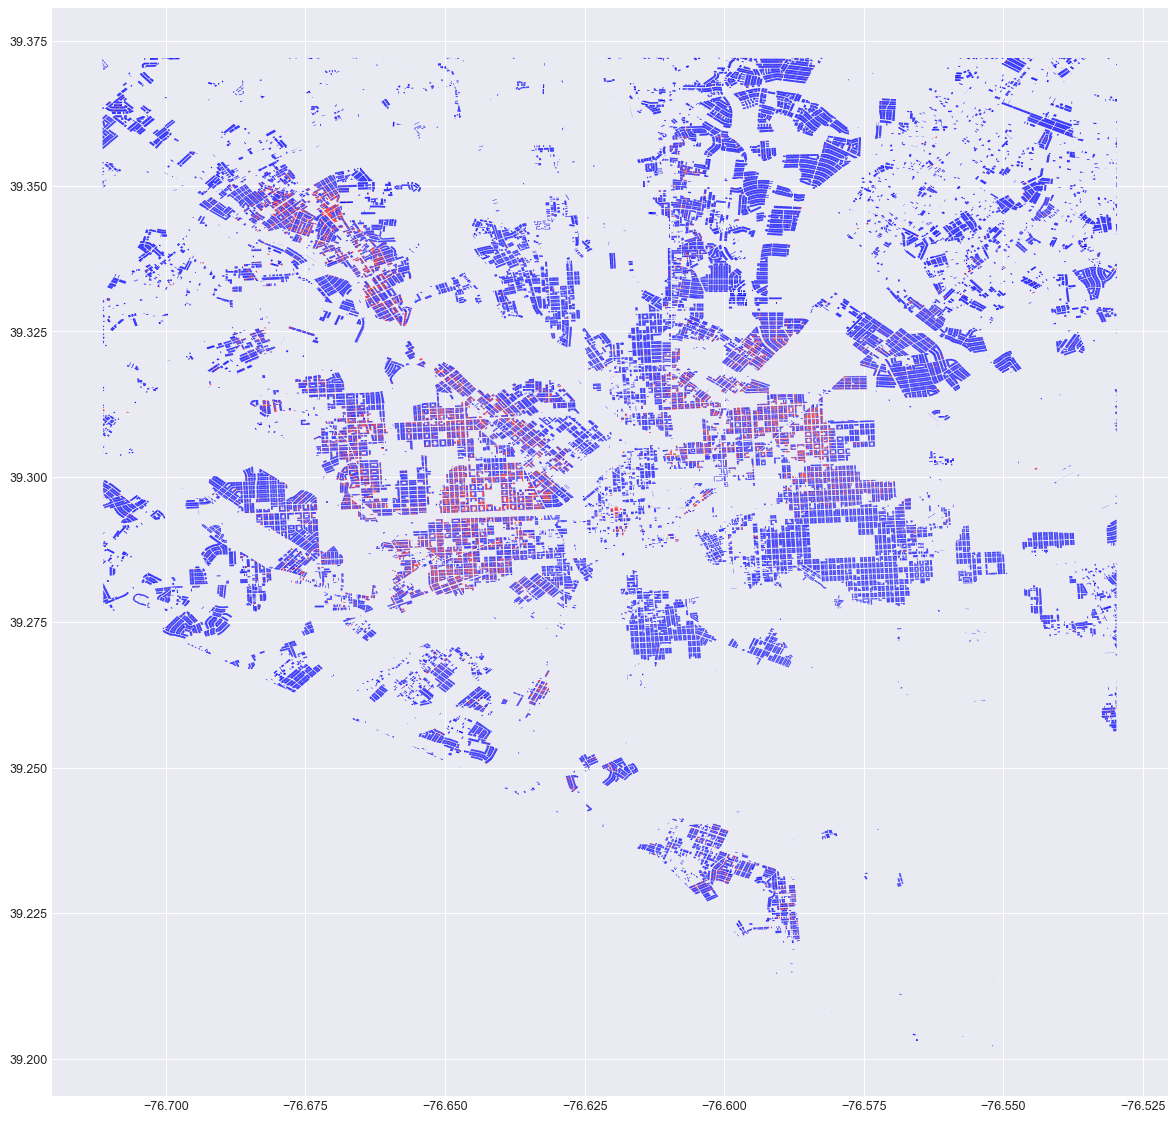

In [36]:
fig = plt.figure(1, figsize=(16,16), dpi=90)
ax = fig.add_subplot(111)
ogdf.plot(ax = ax,color = 'b')
vgdf.plot(ax=ax,color = 'r')

## Revisit Distance

In [11]:
gdf.crs = {'init' :'epsg:4326'}

In [12]:
from math import radians
gdf['x'] = gdf.geometry.centroid.x
gdf['xradians'] = gdf.x.apply(radians)
gdf['y'] = gdf.geometry.centroid.y
gdf['yradians'] = gdf.y.apply(radians)
gdf['yx'] = zip(gdf.y,gdf.x)

In [13]:
import time

In [14]:
s = time.time()
import geopy.distance as gpydistance
gdf.yx[:].apply(lambda var: gpydistance.vincenty(var,gdf.yx[:1])*1000)
print time.time()-s

29.535820961


In [15]:
s = time.time()
from geopy.distance import great_circle
gdf.yx[:].apply(lambda var: great_circle(var,gdf.yx.iloc[0]).meters)
print time.time()-s

8.40938282013


In [16]:
# math package
# approximate radius of earth in meters
from math import sin, cos, sqrt, atan2
def real_dis(col,lon2,lat2):
    lon1, lat1 = col
    R = 6373.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c*1000
s = time.time()
gdf[['xradians','yradians']][:].apply(real_dis, args=(gdf.xradians.iloc[0], gdf.yradians.iloc[0],),axis = 1)
print time.time()-s

4.05679702759


In [17]:
# skip last rows
# ( (137238 rows affected)	NaN	NaN	NaN )
df2 = pd.read_csv('OriginalDataBaseFile/RealGoodNeighbors.csv',low_memory=False,skiprows = lambda x: x == 137240 )
df2.info()
df2.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137238 entries, 0 to 137237
Data columns (total 4 columns):
aID          137238 non-null int64
aBlockLot    137238 non-null object
bID          137238 non-null int64
bBlockLot    137238 non-null object
dtypes: int64(2), object(2)
memory usage: 4.2+ MB


,aID,aBlockLot,bID,bBlockLot
0,2,0001 005,59,0001 006


In [18]:
# check data only appair in edge set
idseta = set(df2.aID.unique())
idsetb = set(df2.bID.unique())
idsettotal = idseta.union(idsetb)
#gdf = gdf[gdf.ID.apply(lambda var: var in idsettotal)]
print len(df2)

137238


In [19]:
# final edge set
gdf['xyradians'] = zip(gdf.xradians,gdf.yradians)
gdf['xyrID'] = zip(gdf.xyradians,gdf.ID)
df2 = df2[(df2.aID.isin(set(gdf.ID))) & (df2.bID.isin(set(gdf.ID)))]
ogdf = gdf[gdf.IsVacant == 0]
vgdf = gdf[gdf.IsVacant == 1]
# houseset
print "total:", len(gdf)
print "residents:" ,len(ogdf)
print "vacant:", len(vgdf)
print "edges:", len(df2)

total: 176474
residents: 160748
vacant: 15726
edges: 132489


Text(0.5,1,u'adjacent plot')

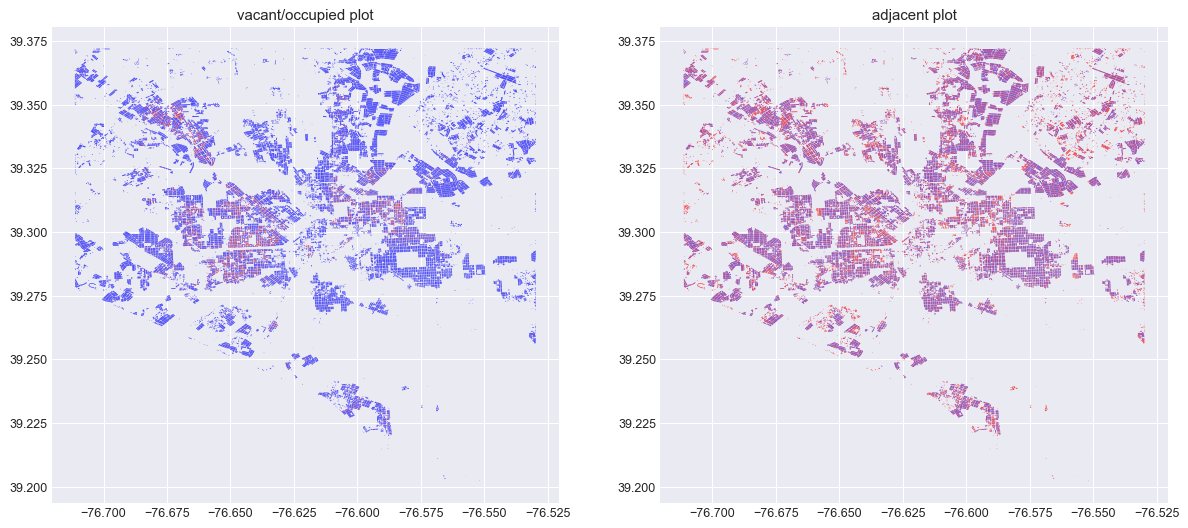

In [150]:
fig = plt.figure(1, figsize=(16,7), dpi=90)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ogdf.plot(ax = ax1,color = 'b')
vgdf.plot(ax=ax1,color = 'r')
ax1.set_title("vacant/occupied plot")

gdf1 = gdf[gdf.ID.apply(lambda var: var in idseta)]
gdf2 = gdf[gdf.ID.apply(lambda var: var not in idseta)]
gdf1.plot(ax = ax2,color = 'b')
gdf2.plot(ax=ax2,color = 'r')
ax2.set_title("adjacent plot")

In [20]:
from gurobipy import *
import numpy as np

### Get Edge Set

In [21]:
#(df2.aID.apply(lambda var: var in set(gdf.ID))) and (df2.bID.apply(lambda var: var in set(gdf.ID))) 
amerge = pd.merge(df2,gdf,left_on=["aID"],right_on=["ID"])

In [22]:
bmerge = pd.merge(df2,gdf,left_on=["bID"],right_on=["ID"])

In [23]:
edge = pd.merge(amerge,bmerge,left_on=["aID","bID"],right_on=["aID","bID"]).iloc[:,:4]

In [24]:
#gdf,ogdf,vgdf,edge

In [25]:
Budget = 500000
demolish_2_story, demolish_3_story = 13000, 22000
r_relocate, o_relocate = 85000, 170000
wall_2_story, wall_3_story = 14000, 25000
cost_reduction = 2000

In [26]:
# cost
Cost = [ 13000 +
      (85000 if gdf.loc[i,"IsVacant"]== 0 else 0) 
        for i in gdf.index ]

# Rdduction
Benefit = [ cost_reduction
             for i in xrange(len(edge))]

# 01-10-18
wi = [ 14000 
     for i in xrange(len(edge))]

wj = [ 14000 
         for i in xrange(len(edge))]

In [27]:
print("Cost:" , Cost[:5])
print("Wall for i:" , wi[:5])
print("Wall for j:" , wj[:5])
print("cost reduction:" , Benefit[:5])

('Cost:', [13000, 98000, 98000, 13000, 98000])
('Wall for i:', [14000, 14000, 14000, 14000, 14000])
('Wall for j:', [14000, 14000, 14000, 14000, 14000])
('cost reduction:', [2000, 2000, 2000, 2000, 2000])


In [28]:
test0 = Model() # empty
test0.Params.Threads = 4
x = test0.addVars(gdf.ID,vtype = GRB.BINARY,name = "x")
#z = test0.addVars(Edge,vtype = GRB.BINARY,name = "z")

edgetuple = zip(edge.aID,edge.bID)
y = test0.addVars(edgetuple,vtype = GRB.BINARY,name = "y")
#bigM = test0.addVars(vgdf.ID,vtype = GRB.CONTINUOUS,name = "bigM",lb = -GRB.INFINITY, ub = 0.0)

Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0


In [29]:
test0.update()
Budget_Constraint = test0.addConstr((quicksum(Cost[i]*x[gdf.ID.iloc[i]] for i in xrange(len(gdf))) -
                     quicksum((Benefit[i]+wi[i]+wj[i])*y[edgetuple[i]] for i in xrange(len(edgetuple))) +
                     quicksum(wi[i]*x[edgetuple[i][1]] for i in xrange(len(edgetuple))) +
                     quicksum(wj[i]*x[edgetuple[i][0]] for i in xrange(len(edgetuple))) 
                     <= 
                     Budget 
                    )
                     , name = "Budget_Constraint")

CD1 = test0.addConstrs((x[edgetuple[i][1]] + x[edgetuple[i][0]] - y[edgetuple[i]] <= 1 
                      for i in xrange(len(edgetuple))
                     ),name = "CD1")

CD2 = test0.addConstrs((-x[edgetuple[i][1]]  + y[edgetuple[i]] <= 0 
                      for i in xrange(len(edgetuple))
                     ),name = "CD2")

CD3 = test0.addConstrs((-x[edgetuple[i][0]]  + y[edgetuple[i]] <= 0 
                      for i in xrange(len(edgetuple))
                     ),name = "CD3")

In [58]:
test0.setObjective( quicksum(x[i] for i in gdf.ID), GRB.MAXIMIZE)
test0.optimize()

Optimize a model with 397472 rows, 308963 columns and 1236562 nonzeros
Variable types: 0 continuous, 308963 integer (308963 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+05]
Found heuristic solution: objective 7
Presolve removed 0 rows and 22496 columns
Presolve time: 3.56s
Presolved: 397472 rows, 286467 columns, 1214058 nonzeros

MIP start did not produce a new incumbent solution
MIP start violates constraint temp by 1.000000000

Variable types: 0 continuous, 286467 integer (286464 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   66472    3.4593134e+04   1.378567e+05   0.000000e+00      5s
  141396    9.6434394e+03   1.866768e+04   0.000000e+00     36s
  144020    9.6434394e+03   1.866768e+04   0.000000e+00     62s
  146646    9.6434355e+03   1.866468e+04   0.000000e+00     92s
  149273    9.6434316e+03   1.866468e+04   0

In [59]:
xcoord = vgdf[ (vgdf.ID.apply(lambda var: abs(x[var].X -1) < 0.00001 ))  ].geometry.centroid.x
ycoord = vgdf[ (vgdf.ID.apply(lambda var: abs(x[var].X -1) < 0.00001 ))  ].geometry.centroid.y

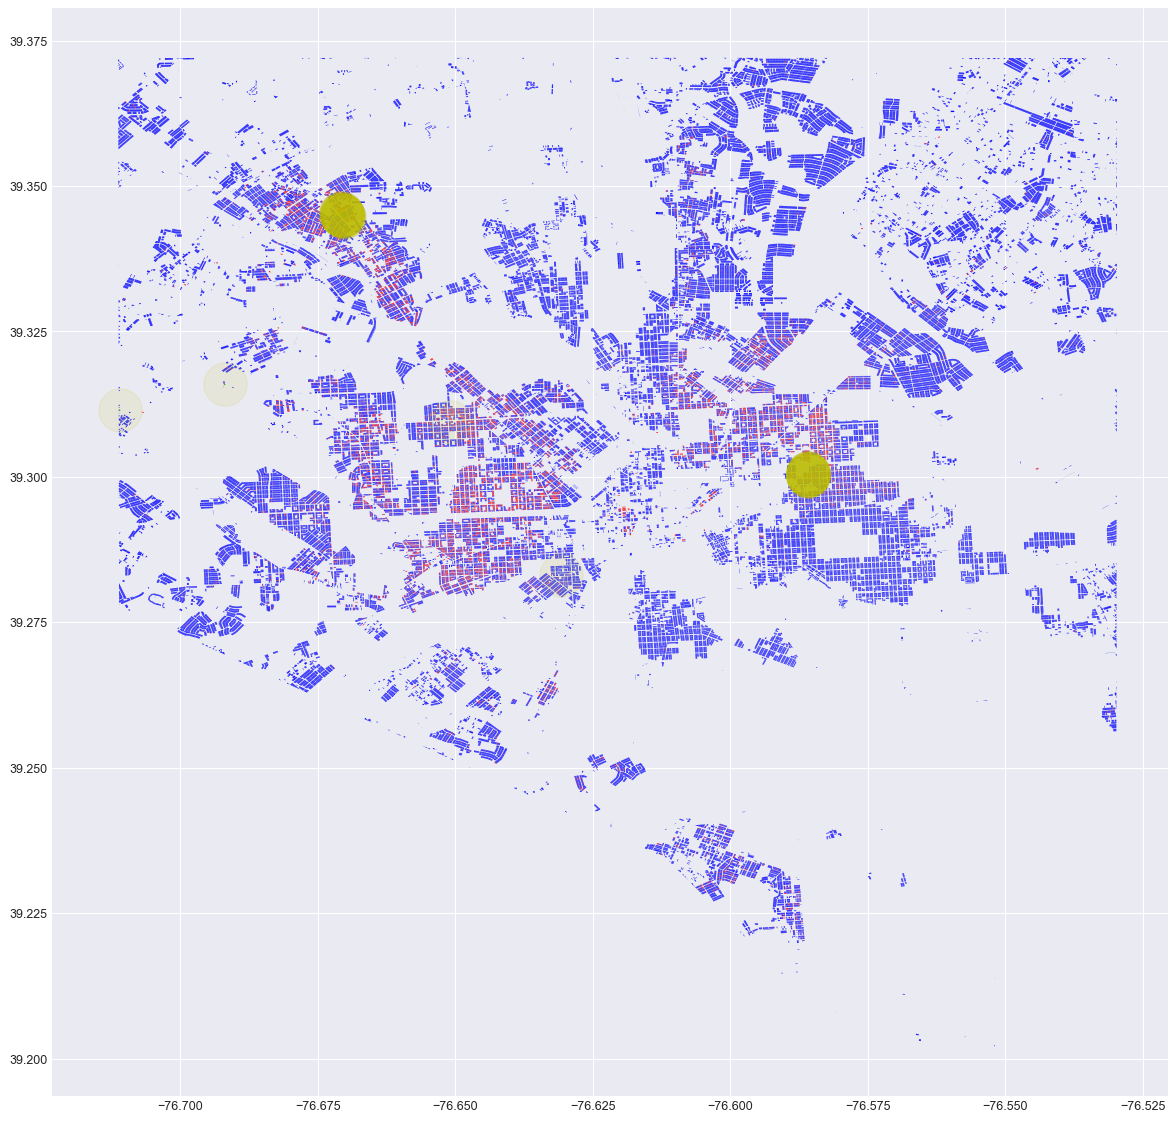

In [60]:
fig = plt.figure(1, figsize=(16,16), dpi=90)
ax = fig.add_subplot(111)
ogdf.plot(ax = ax,color = 'b')
vgdf[vgdf.ID.apply(lambda var: abs(x[var].x -1) < 0.00001 ) ].plot(ax = ax, color = 'g')
vgdf[vgdf.ID.apply(lambda var: abs(x[var].x -1) > 0.00001 ) ].plot(ax = ax, color = 'r')

fig.savefig('newimages/maxhouse-05.eps',format='eps', dpi=1000,bbox_inches='tight')
plt.scatter(x=xcoord, y=ycoord, alpha=0.1, c='y',s = 1200)
fig.savefig('newimages/maxhouse-05.svg', format='svg', dpi=1200,bbox_inches='tight')

In [61]:
#status = []

In [62]:
spent = (sum(Cost[i]*x[gdf.ID.iloc[i]].X for i in xrange(len(gdf))) -
         sum((Benefit[i]+wi[i]+wj[i])*y[edgetuple[i]].X for i in xrange(len(edgetuple))) +
         sum(wi[i]*x[edgetuple[i][1]].X for i in xrange(len(edgetuple))) +
         sum(wj[i]*x[edgetuple[i][0]].X for i in xrange(len(edgetuple))) )
         
        
num_houses = sum(x[i].X  for i in gdf.ID)
    
#print "Budget : %s   number of houses : %s" %(spent, num_houses)
print("Budget : %s   number of houses : %s   ObjVal : %s   Running Time : %s" %
       (spent,num_houses,test0.ObjVal,test0.Runtime))
status.append("Budget : %s   number of houses : %s   ObjVal : %s   Running Time : %s" %
       (spent,num_houses,test0.ObjVal,test0.Runtime))

Budget : 496000.0   number of houses : 44.0   ObjVal : 44.0   Running Time : 173.871219873


In [63]:
status

['Budget : 496000.0   number of houses : 44.0   ObjVal : 44.0   Running Time : 190.833321095',
 'Budget : 496000.0   number of houses : 44.0   ObjVal : 44.0   Running Time : 252.513362885',
 'Budget : 496000.0   number of houses : 44.0   ObjVal : 44.0   Running Time : 199.161182165',
 'Budget : 496000.0   number of houses : 44.0   ObjVal : 44.0   Running Time : 178.347606897',
 'Budget : 496000.0   number of houses : 44.0   ObjVal : 44.0   Running Time : 173.871219873']

In [64]:
if sum(x[gdf.ID.iloc[i]].X for i in xrange(len(gdf))) != 0:

    test0.addConstr(
        (
        quicksum(x[gdf.ID.iloc[i]] 
                 if x[gdf.ID.iloc[i]].X == 1 or abs(x[gdf.ID.iloc[i]].X - 1.0) < 0.000001 
                 else 0 for i in xrange(len(gdf)))
        <= sum( 1
               if x[gdf.ID.iloc[i]].X == 1 or abs(x[gdf.ID.iloc[i]].X - 1.0) < 0.000001 
               else 0 for i in xrange(len(gdf)))-1
        ),name = 'temp'
    )

In [98]:
# write model
test0.write('model-01-28-18.lp')
test0.write('model-01-28-18.mps') 
test0.write('model-01-28-18.prm') 

In [65]:
gdf["demolish"] = gdf.ID.apply(lambda var: x[var].x)

In [66]:
gdf[gdf.demolish == 1].Block.value_counts()

4622    21
1606    19
8415     1
0001     1
8468     1
0847     1
Name: Block, dtype: int64

# Parallel constraint generation is not possible in Gurobi ( or slower )

https://groups.google.com/forum/#!msg/gurobi/0t8_5wtjYSI/67awe7QcBAAJ

In [170]:
from geopy.distance import great_circle
#newport_ri = (41.49008, -71.312796)
#cleveland_oh = (41.499498, -81.695391)
#great_circle(newport_ri, cleveland_oh).meters

def affect(x1,x2):
    dis = great_circle((x1.x,x1.y),
              (x2.x,x2.y)).meters
    return 1.0/dis if dis <= 240 else 0
#print affect(Map[1][1],Map[1][2])

In [42]:
thread = 5

from multiprocessing import Process
from joblib import Parallel, delayed
import time
s = time.time()

#def producer():
#    for i in range(10):
#        yield i

def f(h):
    #l.acquire()
    
    test0.addConstrs(( bigM[ogdf.ID.iloc[i]] 
                     <= quicksum(
                        affect(ogdf.geometry.iloc[i].centroid,
                               vgdf.geometry.iloc[v].centroid)
                              *(x[vgdf.ID.iloc[v]]-1) for v in xrange(len(vgdf))) + 200000.0*x[ogdf.ID.iloc[i]] 
                      for i in xrange(h-thread,h)) 
                    , name = "for each occupied") 
    """
    if (h+1)%10 == 0:
        sys.stdout.write(str(1.0*(h+1)/153788*100)+" , "+str(time.time()-s)+'\r')
        sys.stdout.flush()
    """
    #print "g"
    #l.release()

Parallel(n_jobs=4,backend="threading")(delayed(f)(i) for i in  xrange(thread,81,thread))

        
print("time:", (time.time()-s)/80  )

('time:', 5.106696212291718)


In [81]:
#test0.Params.Threads = 0
from multiprocessing import Process
from joblib import Parallel, delayed
import time
s = time.time()

#def producer():
#    for i in range(10):
#        yield i

def f(i):
    #l.acquire()
   
    
    test0.addConstr(( bigM[ogdf.ID.iloc[i]] 
                     <= quicksum(
                        affect(ogdf.geometry.iloc[i].centroid,
                               vgdf.geometry.iloc[v].centroid)
                              *(x[vgdf.ID.iloc[v]]-1) for v in xrange(len(vgdf))) + 200000.0*x[ogdf.ID.iloc[i]] 
                     ) 
                    , name = "for each occupied") 
    test0.update()
    if (i+1)%10 == 0:
        sys.stdout.write(str(1.0*(i+1)/153788*100)+" percent , "+str(time.time()-s)+'\r')
        sys.stdout.flush()
    
    rtn = 99
    #print "g"
    #l.release()

Parallel(n_jobs=4)(delayed(f)(i) for i in  xrange(0,80))

        
print("time:", (time.time()-s)/80 )

('time:', 1.2877171248197556).921424158


In [38]:
from multiprocessing import Pool, TimeoutError
import time
import os
import sys



def f(h):
    #total = sum( [affect(ogdf.geometry.iloc[h].centroid,vgdf.geometry.iloc[v].centroid) 
    #              for v in xrange(len(vgdf))])
    
    global count
    global s
    if count > 50:
        return
    
    
    test0.addConstr(( bigM[ogdf.ID.iloc[h]] 
                     <= quicksum(
                        affect(ogdf.geometry.iloc[h].centroid,
                               vgdf.geometry.iloc[v].centroid)
                              *(x[vgdf.ID.iloc[v]]-1) for v in xrange(len(vgdf))) + 200000.0*x[ogdf.ID.iloc[h]] ) , name = "for each occupied") 
    

    count += 1
    
    if (count)%10 == 0:
        sys.stdout.write(str(1.0*(count)/153788*100)+" , "+str(time.time()-s)+'\r')
        sys.stdout.flush()

    
    
if __name__ == '__main__':
    

    pool = Pool(processes=3)
    
    count = 0
    s = 0
    pool.map(f, range(3))
    # allows the system to recognize four total "cores" or "threads" (two real and two virtual).
    
    s = time.time() 
    count = 0
    
    pool.map(f, range(len(ogdf)))
    
    pool.close()
    #test0.setObjective( quicksum(bigM[i] for i in Occupied), GRB.MAXIMIZE)

print("time:", time.time()-s)

('time:', 248.27418208122253)64


In [177]:
len(ogdf)

68583